# Transfer Learning + Fine-tuning


### Imports

In [8]:
import os, glob, platform, random, json, math, copy, time
from pathlib import Path
import numpy as np
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from contextlib import nullcontext

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import models
from torch.optim.lr_scheduler import CosineAnnealingLR

from tqdm.auto import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt

### Config

In [9]:
# Configuración del dataset
DATA_ROOT   = "E:/TFM/Dataset_una_clase"   # {train,val,test}/{negative,positive}
IMAGE_SIZE  = 224
BATCH_SIZE  = 16
SEED        = 42

# 0 para evitar errores de multiprocessing en Windows
NUM_WORKERS = 0 if platform.system().lower().startswith("win") else 4

# Entrenamiento
EPOCHS          = 40
WARMUP_EPOCHS   = 8
LR_HEAD         = 1e-3
LR_BACKBONE     = 1e-4
WEIGHT_DECAY    = 1e-4
PATIENCE        = 10
OUT_DIR         = "E:/TFM/modelos/Outputs_Transfer"

# Opciones
USE_BALANCED_SAMPLER = True      # poner False para no balancear
USE_FOCAL            = True      # usar FocalLoss (si False, usa BCEWithLogits)
FOCAL_GAMMA          = 2.0
FOCAL_ALPHA          = 0.25      # usado si AUTO_ALPHA=False
AUTO_ALPHA           = True      # si True, alpha ≈ (1 - prevalencia_positiva)

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibilidad
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed()


Device: cuda


### Transforms

In [10]:

def _resize(img_size: int):
    return A.Resize(height=img_size, width=img_size)

def _random_resized_crop(img_size: int):
    try:
        return A.RandomResizedCrop(size=(img_size, img_size), scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)
    except TypeError:
        return A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.9, 1.0), ratio=(0.9, 1.1), p=1.0)

train_tf = A.Compose([
    _random_resized_crop(IMAGE_SIZE),
    A.Affine(
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
        scale=(0.9, 1.1),
        rotate=(-7, 7),
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_CONSTANT,
        p=0.9
    ),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.10, contrast_limit=0.10, p=0.7),
    A.GaussianBlur(blur_limit=(3, 3), p=0.2),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
    ToTensorV2(),
])

eval_tf = A.Compose([
    _resize(IMAGE_SIZE),
    A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]),
    ToTensorV2(),
])


### Dataset

In [11]:

# Dataset
class ChestXrayDataset(Dataset):
    def __init__(self, root_split_dir, transform=None):
        self.root = root_split_dir
        self.transform = transform
        self.class_to_idx = {"negative": 0, "positive": 1}
        self.samples = []
        
        exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp", "*.tif", "*.tiff")
        for cls in ["negative", "positive"]:
            for ext in exts:
                for f in glob.glob(os.path.join(self.root, cls, ext)):
                    self.samples.append((f, self.class_to_idx[cls]))
        
        # filtrar ilegibles
        valid, skipped = [], []
        for path, label in self.samples:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None or img.size == 0:
                skipped.append(path)
            else:
                valid.append((path, label))
        if skipped:
            print(f"[WARN] {len(skipped)} imágenes ilegibles en {self.root}, se omiten.")
        self.samples = shuffle(valid, random_state=SEED)
        if len(self.samples) == 0:
            raise RuntimeError(f"No hay imágenes válidas en {self.root}")
    
    def __len__(self): 
        return len(self.samples)
    
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        if self.transform: 
            img = self.transform(image=img)["image"]
        return img, torch.tensor(label, dtype=torch.long)

def make_loaders():
    train_ds = ChestXrayDataset(os.path.join(DATA_ROOT, "train"), transform=train_tf)
    val_ds   = ChestXrayDataset(os.path.join(DATA_ROOT, "val"),   transform=eval_tf)
    test_ds  = ChestXrayDataset(os.path.join(DATA_ROOT, "test"),  transform=eval_tf)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=False)
    val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=False)
    test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=False)
    return train_loader, val_loader, test_loader, train_ds, val_ds, test_ds

train_loader, val_loader, test_loader, train_ds, val_ds, test_ds = make_loaders()
print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
imgs, labels = next(iter(train_loader))
print("Batch shape:", imgs.shape, "| Labels shape:", labels.shape)
print("Post-Normalize -> mean:", imgs.float().mean().item(), "std:", imgs.float().std().item())


Train: 278 | Val: 93 | Test: 93
Batch shape: torch.Size([16, 3, 224, 224]) | Labels shape: torch.Size([16])
Post-Normalize -> mean: -0.12879136204719543 std: 1.1381198167800903


### Sampler + Alpha

In [12]:
if USE_BALANCED_SAMPLER:
    labels_list = [lab for _, lab in train_ds.samples]
    class_counts = np.bincount(labels_list, minlength=2)
    class_weights = 1.0 / np.maximum(class_counts, 1)
    sample_weights = [class_weights[lab] for lab in labels_list]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    train_loader_balanced = DataLoader(
        train_ds, batch_size=BATCH_SIZE, sampler=sampler,
        num_workers=NUM_WORKERS, pin_memory=False
    )
    print("Distribución original:", dict(zip(range(len(class_counts)), class_counts)))
    train_loader = train_loader_balanced

# Alpha recomendado para Focal ≈ (1 - prevalencia_positiva)
if AUTO_ALPHA:
    labels_for_alpha = [lab for _, lab in train_ds.samples]
    n_pos = sum(labels_for_alpha)
    n_total = len(labels_for_alpha)
    preval = n_pos / max(1, n_total)
    FOCAL_ALPHA = float(max(0.01, min(0.99, 1.0 - preval)))
    print(f"Prevalencia positivos: {preval:.4f} -> alpha (Focal): {FOCAL_ALPHA:.3f}")


Distribución original: {0: np.int64(139), 1: np.int64(139)}
Prevalencia positivos: 0.5000 -> alpha (Focal): 0.500


### Modelo y entrenamiento

In [13]:
def make_grad_scaler(device):
    if device.type != "cuda":
        return None
    if hasattr(torch, "amp"):
        # Algunas versiones aceptan un primer arg posicional "cuda", otras ninguno.
        for ctor in (lambda: torch.amp.GradScaler("cuda"),
                     lambda: torch.amp.GradScaler()):
            try:
                return ctor()
            except TypeError:
                continue
    try:
        return torch.cuda.amp.GradScaler()
    except Exception:
        return None
    
def autocast_ctx(device):
    if device.type != "cuda":
        return nullcontext()
    if hasattr(torch, "amp"):
        try:
            return torch.amp.autocast("cuda")
        except TypeError:
            return torch.amp.autocast(device_type="cuda")
        except Exception:
            return nullcontext()
    return torch.cuda.amp.autocast()

In [14]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        pt = probs*targets + (1-probs)*(1-targets)
        loss = (self.alpha*(1-pt)**self.gamma)*bce
        if self.reduction == 'mean':
            return loss.mean()
        if self.reduction == 'sum':
            return loss.sum()
        return loss

def build_model(pretrained=True):
    try:
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        model = models.resnet50(weights=weights)
    except Exception:
        model = models.resnet50(pretrained=pretrained)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)  # binario (1 logit)
    return model

@torch.no_grad()
def evaluate(model, loader, device, threshold=0.5):
    model.eval()
    all_logits, all_targets = [], []
    correct, total = 0, 0
    for x, y in loader:
        x = x.to(device)
        y = y.float().unsqueeze(1).to(device)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs >= threshold).float()
        correct += (preds == y).sum().item()
        total += y.numel()
        all_logits.append(logits.cpu().numpy())
        all_targets.append(y.cpu().numpy())
    acc = correct/total if total>0 else 0.0
    logits = np.concatenate(all_logits, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    probs = 1/(1+np.exp(-logits))
    metrics = {"acc": acc}
    try:
        metrics["roc_auc"] = float(roc_auc_score(targets, probs))
        metrics["pr_auc"]  = float(average_precision_score(targets, probs))
        preds05 = (probs >= 0.5).astype(np.int64)
        metrics["f1"] = float(f1_score(targets, preds05))
    except Exception:
        pass
    # sensibilidad @ 95% especificidad
    ts = np.linspace(0,1,101)
    best_sens = None
    for t in ts:
        preds = (probs >= t).astype(np.int64)
        tn = np.sum((preds==0) & (targets==0))
        fp = np.sum((preds==1) & (targets==0))
        tp = np.sum((preds==1) & (targets==1))
        fn = np.sum((preds==0) & (targets==1))
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        if spec >= 0.95:
            best_sens = sens if (best_sens is None or sens>best_sens) else best_sens
    if best_sens is not None:
        metrics["sens_at_95spec"] = float(best_sens)
    return metrics


In [15]:
def train(
    train_loader, val_loader, test_loader,
    epochs, warmup_epochs,
    lr_head, lr_backbone,
    weight_decay,
    use_focal, gamma, alpha,
    patience, out_dir,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
):
    os.makedirs(out_dir, exist_ok=True)
    model = build_model(pretrained=True).to(device)

    # congelar backbone
    for name, p in model.named_parameters():
        if not name.startswith("fc"):
            p.requires_grad = False
    params_head = [p for p in model.parameters() if p.requires_grad]
    opt = optim.AdamW(params_head, lr=lr_head, weight_decay=weight_decay)
    sch = CosineAnnealingLR(opt, T_max=warmup_epochs)
    criterion = FocalLoss(gamma=gamma, alpha=alpha) if use_focal else nn.BCEWithLogitsLoss()

    # --- AMP compatible ---
    scaler = make_grad_scaler(device)

    best_metric, best_state, epochs_no_improve = -1, None, 0

    # ---------- Warmup ----------
    for ep in range(warmup_epochs):
        model.train()
        losses = []
        for x, y in tqdm(train_loader, desc=f"Warmup {ep+1}/{warmup_epochs}"):
            x = x.to(device); y = y.float().unsqueeze(1).to(device)
            opt.zero_grad(set_to_none=True)
            if scaler:
                with autocast_ctx(device):
                    logits = model(x)
                    loss = criterion(logits, y)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                logits = model(x); loss = criterion(logits, y)
                loss.backward(); opt.step()
            losses.append(loss.item())
        sch.step()
        val_metrics = evaluate(model, val_loader, device)
        metric = val_metrics.get("pr_auc", val_metrics.get("roc_auc", val_metrics.get("acc", 0.0)))
        print(f"loss={np.mean(losses):.4f} | val:", val_metrics)
        if metric > best_metric:
            best_metric, epochs_no_improve = metric, 0
            best_state = copy.deepcopy(model.state_dict())
            torch.save(best_state, os.path.join(out_dir, "best_warmup.pt"))
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping (warmup)"); break

    # ---------- Fine-tune ----------
    for p in model.parameters(): p.requires_grad = True
    opt = optim.AdamW(model.parameters(), lr=lr_backbone, weight_decay=weight_decay)
    sch = CosineAnnealingLR(opt, T_max=max(1, epochs - warmup_epochs))
    epochs_no_improve = 0  # reinicia paciencia

    for ep in range(warmup_epochs, epochs):
        model.train()
        losses = []
        for x, y in tqdm(train_loader, desc=f"Fine-tune {ep+1}/{epochs}"):
            x = x.to(device); y = y.float().unsqueeze(1).to(device)
            opt.zero_grad(set_to_none=True)
            if scaler:
                with autocast_ctx(device):
                    logits = model(x)
                    loss = criterion(logits, y)
                scaler.scale(loss).backward()
                scaler.step(opt); scaler.update()
            else:
                logits = model(x); loss = criterion(logits, y)
                loss.backward(); opt.step()
            losses.append(loss.item())
        sch.step()
        val_metrics = evaluate(model, val_loader, device)
        metric = val_metrics.get("pr_auc", val_metrics.get("roc_auc", val_metrics.get("acc", 0.0)))
        print(f"loss={np.mean(losses):.4f} | val:", val_metrics)
        if metric > best_metric:
            best_metric, epochs_no_improve = metric, 0
            best_state = copy.deepcopy(model.state_dict())
            torch.save(best_state, os.path.join(out_dir, "best_model.pt"))
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping (fine-tune)"); break

    if best_state is not None:
        model.load_state_dict(best_state)
    test_metrics = evaluate(model, test_loader, device)
    with open(os.path.join(out_dir, "test_metrics.json"), "w") as f:
        json.dump(test_metrics, f, indent=2)
    print("=== Test ===", test_metrics)
    return model, test_metrics

In [16]:
model, test_metrics = train(
    train_loader=train_loader, val_loader=val_loader, test_loader=test_loader,
    epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS,
    lr_head=LR_HEAD, lr_backbone=LR_BACKBONE,
    weight_decay=WEIGHT_DECAY,
    use_focal=USE_FOCAL, gamma=FOCAL_GAMMA, alpha=FOCAL_ALPHA,
    patience=PATIENCE, out_dir=OUT_DIR
)


Warmup 1/8: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


loss=0.0860 | val: {'acc': 0.4946236559139785, 'roc_auc': 0.6308973172987974, 'pr_auc': 0.6444923853550867, 'f1': 0.0, 'sens_at_95spec': 0.1276595744680851}


Warmup 2/8: 100%|██████████| 18/18 [00:14<00:00,  1.26it/s]


loss=0.0825 | val: {'acc': 0.5053763440860215, 'roc_auc': 0.5370027752081407, 'pr_auc': 0.544171955155764, 'f1': 0.041666666666666664, 'sens_at_95spec': 0.0425531914893617}


Warmup 3/8: 100%|██████████| 18/18 [00:14<00:00,  1.24it/s]


loss=0.0825 | val: {'acc': 0.5268817204301075, 'roc_auc': 0.6308973172987974, 'pr_auc': 0.6133462967730688, 'f1': 0.18518518518518517, 'sens_at_95spec': 0.10638297872340426}


Warmup 4/8: 100%|██████████| 18/18 [00:14<00:00,  1.27it/s]


loss=0.0796 | val: {'acc': 0.5698924731182796, 'roc_auc': 0.7118408880666051, 'pr_auc': 0.7137364221937319, 'f1': 0.4594594594594595, 'sens_at_95spec': 0.2553191489361702}


Warmup 5/8: 100%|██████████| 18/18 [00:13<00:00,  1.36it/s]


loss=0.0768 | val: {'acc': 0.5806451612903226, 'roc_auc': 0.7608695652173912, 'pr_auc': 0.7553228157775324, 'f1': 0.36065573770491804, 'sens_at_95spec': 0.2127659574468085}


Warmup 6/8: 100%|██████████| 18/18 [00:13<00:00,  1.29it/s]


loss=0.0736 | val: {'acc': 0.6451612903225806, 'roc_auc': 0.7733580018501387, 'pr_auc': 0.7689169264199296, 'f1': 0.5217391304347826, 'sens_at_95spec': 0.2127659574468085}


Warmup 7/8: 100%|██████████| 18/18 [00:13<00:00,  1.32it/s]


loss=0.0762 | val: {'acc': 0.6236559139784946, 'roc_auc': 0.7622571692876966, 'pr_auc': 0.7757750719996738, 'f1': 0.4444444444444444, 'sens_at_95spec': 0.2978723404255319}


Warmup 8/8: 100%|██████████| 18/18 [00:14<00:00,  1.28it/s]


loss=0.0761 | val: {'acc': 0.5913978494623656, 'roc_auc': 0.7682701202590194, 'pr_auc': 0.7677959039990546, 'f1': 0.36666666666666664, 'sens_at_95spec': 0.23404255319148937}


Fine-tune 9/40: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


loss=0.0733 | val: {'acc': 0.6451612903225806, 'roc_auc': 0.7617946345975948, 'pr_auc': 0.7756829467778371, 'f1': 0.56, 'sens_at_95spec': 0.2765957446808511}


Fine-tune 10/40: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


loss=0.0639 | val: {'acc': 0.7634408602150538, 'roc_auc': 0.849213691026827, 'pr_auc': 0.8588905975416848, 'f1': 0.7105263157894737, 'sens_at_95spec': 0.6170212765957447}


Fine-tune 11/40: 100%|██████████| 18/18 [00:15<00:00,  1.20it/s]


loss=0.0540 | val: {'acc': 0.6236559139784946, 'roc_auc': 0.8242368177613321, 'pr_auc': 0.8234120203879738, 'f1': 0.4444444444444444, 'sens_at_95spec': 0.40425531914893614}


Fine-tune 12/40: 100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


loss=0.0487 | val: {'acc': 0.7096774193548387, 'roc_auc': 0.837650323774283, 'pr_auc': 0.8639403324940198, 'f1': 0.6197183098591549, 'sens_at_95spec': 0.48936170212765956}


Fine-tune 13/40: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


loss=0.0424 | val: {'acc': 0.7204301075268817, 'roc_auc': 0.8145235892691952, 'pr_auc': 0.7798699090236634, 'f1': 0.6829268292682927, 'sens_at_95spec': 0.19148936170212766}


Fine-tune 14/40: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


loss=0.0399 | val: {'acc': 0.7204301075268817, 'roc_auc': 0.8274745605920444, 'pr_auc': 0.8509628175624974, 'f1': 0.6285714285714286, 'sens_at_95spec': 0.5531914893617021}


Fine-tune 15/40: 100%|██████████| 18/18 [00:15<00:00,  1.13it/s]


loss=0.0363 | val: {'acc': 0.7204301075268817, 'roc_auc': 0.8006475485661424, 'pr_auc': 0.8048456974670294, 'f1': 0.6976744186046512, 'sens_at_95spec': 0.2765957446808511}


Fine-tune 16/40: 100%|██████████| 18/18 [00:14<00:00,  1.22it/s]


loss=0.0270 | val: {'acc': 0.7956989247311828, 'roc_auc': 0.8820536540240519, 'pr_auc': 0.9015573833206965, 'f1': 0.7816091954022989, 'sens_at_95spec': 0.5319148936170213}


Fine-tune 17/40: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


loss=0.0244 | val: {'acc': 0.6989247311827957, 'roc_auc': 0.8825161887141536, 'pr_auc': 0.8927605705895842, 'f1': 0.5882352941176471, 'sens_at_95spec': 0.5106382978723404}


Fine-tune 18/40: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]


loss=0.0250 | val: {'acc': 0.7096774193548387, 'roc_auc': 0.8219241443108234, 'pr_auc': 0.8143718485379033, 'f1': 0.6582278481012658, 'sens_at_95spec': 0.2127659574468085}


Fine-tune 19/40: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


loss=0.0207 | val: {'acc': 0.7526881720430108, 'roc_auc': 0.8256244218316373, 'pr_auc': 0.7831347059406056, 'f1': 0.7228915662650602, 'sens_at_95spec': 0.2127659574468085}


Fine-tune 20/40: 100%|██████████| 18/18 [00:15<00:00,  1.15it/s]


loss=0.0160 | val: {'acc': 0.6666666666666666, 'roc_auc': 0.8334875115633673, 'pr_auc': 0.8063600764404384, 'f1': 0.5753424657534246, 'sens_at_95spec': 0.2765957446808511}


Fine-tune 21/40: 100%|██████████| 18/18 [00:14<00:00,  1.21it/s]


loss=0.0139 | val: {'acc': 0.6559139784946236, 'roc_auc': 0.8501387604070306, 'pr_auc': 0.80618418944553, 'f1': 0.5428571428571428, 'sens_at_95spec': 0.3404255319148936}


Fine-tune 22/40: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]


loss=0.0093 | val: {'acc': 0.7096774193548387, 'roc_auc': 0.870027752081406, 'pr_auc': 0.8733419825858878, 'f1': 0.6301369863013698, 'sens_at_95spec': 0.46808510638297873}


Fine-tune 23/40: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


loss=0.0078 | val: {'acc': 0.7204301075268817, 'roc_auc': 0.8741905642923219, 'pr_auc': 0.846364529762218, 'f1': 0.6666666666666666, 'sens_at_95spec': 0.3829787234042553}


Fine-tune 24/40: 100%|██████████| 18/18 [00:16<00:00,  1.10it/s]


loss=0.0109 | val: {'acc': 0.7204301075268817, 'roc_auc': 0.8695652173913044, 'pr_auc': 0.8289835130289104, 'f1': 0.6666666666666666, 'sens_at_95spec': 0.3191489361702128}


Fine-tune 25/40: 100%|██████████| 18/18 [00:15<00:00,  1.18it/s]


loss=0.0093 | val: {'acc': 0.7634408602150538, 'roc_auc': 0.8950046253469011, 'pr_auc': 0.8989396425583823, 'f1': 0.725, 'sens_at_95spec': 0.44680851063829785}


Fine-tune 26/40: 100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


loss=0.0137 | val: {'acc': 0.6989247311827957, 'roc_auc': 0.8695652173913043, 'pr_auc': 0.8702738851741735, 'f1': 0.6216216216216216, 'sens_at_95spec': 0.3829787234042553}
Early stopping (fine-tune)
=== Test === {'acc': 0.7526881720430108, 'roc_auc': 0.820536540240518, 'pr_auc': 0.8475828099692643, 'f1': 0.7012987012987013, 'sens_at_95spec': 0.5652173913043478}


In [17]:
@torch.no_grad()
def collect_logits_targets(model, loader, device):
    model.eval()
    logits_all, targets_all = [], []
    for x, y in loader:
        x = x.to(device); y = y.float().unsqueeze(1).to(device)
        logits = model(x)
        logits_all.append(logits.cpu().numpy())
        targets_all.append(y.cpu().numpy())
    logits = np.concatenate(logits_all, axis=0).reshape(-1)
    targets = np.concatenate(targets_all, axis=0).reshape(-1)
    probs = 1/(1+np.exp(-logits))
    return probs, targets

def find_threshold_for_spec(probs, targets, target_spec=0.95):
    ts = np.linspace(0,1,1001)
    best = {"thr": 0.5, "sens": 0.0, "spec": 0.0}
    for t in ts:
        preds = (probs >= t).astype(np.int64)
        tn = np.sum((preds==0) & (targets==0))
        fp = np.sum((preds==1) & (targets==0))
        tp = np.sum((preds==1) & (targets==1))
        fn = np.sum((preds==0) & (targets==1))
        spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
        sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
        if spec >= target_spec and sens > best["sens"]:
            best = {"thr": float(t), "sens": float(sens), "spec": float(spec)}
    return best

def find_threshold_max_f1(probs, targets):
    ts = np.linspace(0,1,1001)
    best = {"thr": 0.5, "f1": 0.0}
    for t in ts:
        preds = (probs >= t).astype(np.int64)
        tp = np.sum((preds==1) & (targets==1))
        fp = np.sum((preds==1) & (targets==0))
        fn = np.sum((preds==0) & (targets==1))
        f1 = (2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
        if f1 > best["f1"]:
            best = {"thr": float(t), "f1": float(f1)}
    return best

def evaluate_with_threshold(probs, targets, thr):
    preds = (probs >= thr).astype(np.int64)
    tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
    acc  = (tp+tn)/(tp+tn+fp+fn)
    spec = tn/(tn+fp) if (tn+fp)>0 else 0.0
    sens = tp/(tp+fn) if (tp+fn)>0 else 0.0
    f1   = (2*tp)/(2*tp+fp+fn) if (2*tp+fp+fn)>0 else 0.0
    return {"acc":acc, "sens":sens, "spec":spec, "f1":f1, "tp":tp, "fp":fp, "tn":tn, "fn":fn}

# Umbrales en VAL
probs_val, targets_val = collect_logits_targets(model, val_loader, device)
opt_spec  = find_threshold_for_spec(probs_val, targets_val, target_spec=0.95)
opt_f1    = find_threshold_max_f1(probs_val, targets_val)
print("Umbral ~95% espec (VAL):", opt_spec)
print("Umbral máx F1 (VAL):     ", opt_f1)

# Aplicar en TEST
probs_test, targets_test = collect_logits_targets(model, test_loader, device)
print("\nTEST @ thr(95% spec en VAL):", evaluate_with_threshold(probs_test, targets_test, opt_spec["thr"]))
print("TEST @ thr(max F1 en VAL):   ", evaluate_with_threshold(probs_test, targets_test, opt_f1["thr"]))


Umbral ~95% espec (VAL): {'thr': 0.5710000000000001, 'sens': 0.574468085106383, 'spec': 0.9565217391304348}
Umbral máx F1 (VAL):      {'thr': 0.431, 'f1': 0.8210526315789474}

TEST @ thr(95% spec en VAL): {'acc': np.float64(0.7419354838709677), 'sens': np.float64(0.5), 'spec': np.float64(0.9787234042553191), 'f1': np.float64(0.6571428571428571), 'tp': np.int64(23), 'fp': np.int64(1), 'tn': np.int64(46), 'fn': np.int64(23)}
TEST @ thr(max F1 en VAL):    {'acc': np.float64(0.6774193548387096), 'sens': np.float64(0.6521739130434783), 'spec': np.float64(0.7021276595744681), 'f1': np.float64(0.6666666666666666), 'tp': np.int64(30), 'fp': np.int64(14), 'tn': np.int64(33), 'fn': np.int64(16)}


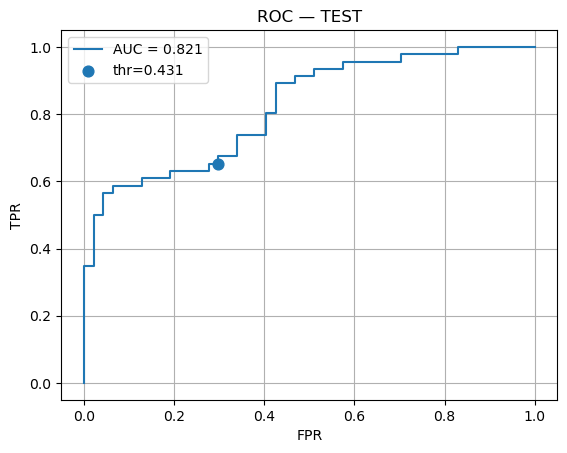

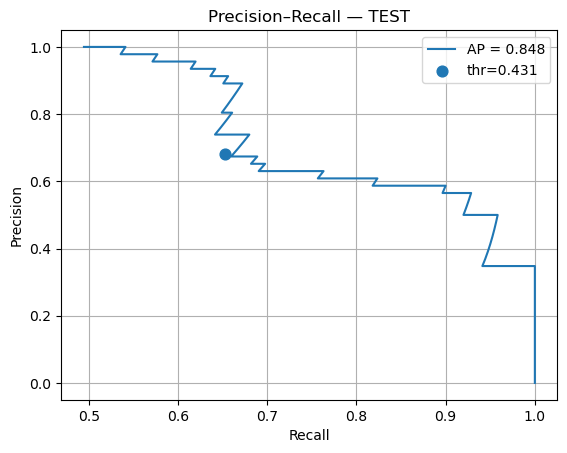

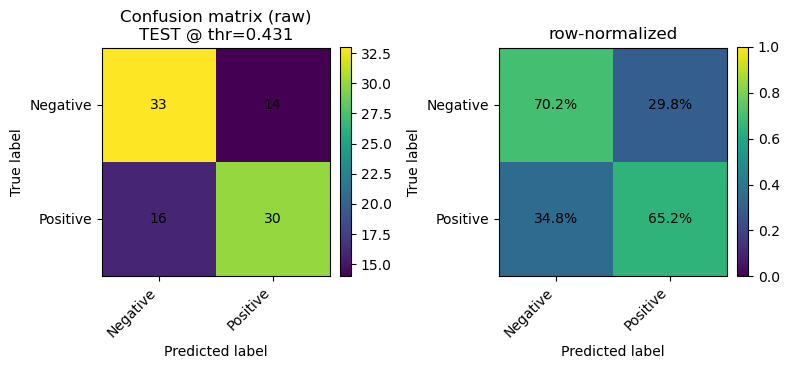

In [18]:
use_thr = "f1"           # "f1" o "spec" (95% especificidad)

probs = probs_test
targets = targets_test
thr = (opt_f1["thr"] if use_thr=="f1" else opt_spec["thr"])
tag = "TEST"

# Métricas globales
auc = roc_auc_score(targets, probs)
ap  = average_precision_score(targets, probs)

# Punto de operación @ thr
preds = (probs >= thr).astype(np.int64)
tn, fp, fn, tp = confusion_matrix(targets, preds, labels=[0,1]).ravel()
tpr_point = tp / (tp + fn) if (tp+fn)>0 else 0.0   # recall
fpr_point = fp / (fp + tn) if (fp+tn)>0 else 0.0
prec_point = tp / (tp + fp) if (tp+fp)>0 else 0.0

# ===== ROC =====
fpr, tpr, _ = roc_curve(targets, probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.scatter([fpr_point],[tpr_point], s=60, marker='o', label=f"thr={thr:.3f}")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title(f"ROC — {tag}")
plt.grid(True); plt.legend(); plt.show()

# ===== PR =====
rec, prec, _ = precision_recall_curve(targets, probs)
plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.scatter([tpr_point],[prec_point], s=60, marker='o', label=f"thr={thr:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"Precision–Recall — {tag}")
plt.grid(True); plt.legend(); plt.show()

# ===== Matriz de confusión: cruda + normalizada =====
cm = confusion_matrix(targets, preds, labels=[0,1])
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.8))

ax = axes[0]
im = ax.imshow(cm, interpolation='nearest')
ax.set_title(f"Confusion matrix (raw)\n{tag} @ thr={thr:.3f}")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, int(cm[i, j]), ha="center", va="center")
ax.set_ylabel('True label'); ax.set_xlabel('Predicted label')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax = axes[1]
im2 = ax.imshow(cm_norm, interpolation='nearest', vmin=0, vmax=1)
ax.set_title("row-normalized")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Negative','Positive']); ax.set_yticklabels(['Negative','Positive'])
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i,j]*100:.1f}%", ha="center", va="center")
ax.set_ylabel('True label'); ax.set_xlabel('Predicted label')
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout(); plt.show()
